In [1]:
import os
import glob
import itertools
import json
import importlib
import copy

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

In [2]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.correlations as cr
import analyze2p.scatter as sct

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Source data

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

## Metdata

In [7]:
# Load RF fit params for good rois
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
|    |   visual_area |
|:---|--------------:|
| V1 |            18 |
| Lm |            15 |
| Li |            15 |


## Select data and output

In [88]:
# Load trial metrics
experiment='rfs'
trial_epoch = 'stimulus'
traceid='traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=7
# ---------------------------------------------
responsive_str = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
Stimulus: rfs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1766 |
| Lm |          1366 |
| Li |           797 |


## Load RF fits

In [86]:
import analyze2p.objects.sim_utils as su

In [89]:
# experiment = 'rfs'
response_type='dff'
do_spherical_correction=False
# ---------------------------------------------------------------
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(CELLS,meta,
                        response_type=response_type,
                        do_spherical_correction=do_spherical_correction,
                        reliable_only=True, pass_criterion=['position', 'size'], 
                        combine='select', ecc_center=(0, 20))
# Add ROI positions
rfdf = aggr.add_roi_positions(rfdf.copy())
# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)
    
# data id
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
traces001|dff_responsive-nstds-thr7.00|rfs-dff-uncorr


In [90]:
# Set output dir
rf_type = 'rfs_sphrcorr' if do_spherical_correction else 'rfs_uncorr'
corr_dir = os.path.join(aggregate_dir, 'correlations', 
                       'rfs_%s_%s' % (response_type, responsive_test))
dst_dir = os.path.join(corr_dir, '%s_metrics' % rf_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics


## Add projection and scatter info

In [12]:
ecc_center=(0, 20)
no_rfs=[]; bad_fits=[];
a_list=[]
for (va, dk, exp), g in rfdf.groupby(['visual_area', 'datakey', 'experiment']):
    regr_np = sct.load_models(dk, va)
    aligned_ = sct.predict_soma_from_gradient(dk, va, regr_np, experiment=exp,
                                response_type=response_type,ecc_center=ecc_center,
                                do_spherical_correction=do_spherical_correction)
#     aligned_ = sct.project_soma_position_in_fov(dk, va, experiment=exp,
#                                 response_type=response_type,
#                                 do_spherical_correction=do_spherical_correction)
    if (regr_np['R2']<0.5).values.all():
        bad_fits.append((va, dk, exp))
        continue
    if aligned_ is None:
        no_rfs.append((va, dk, exp))
        continue
    for p in ['R2', 'RMSE', 'coefficient', 'intercept']:
        r2_ml = float(regr_np[regr_np.cond=='az'][p])
        r2_ap = float(regr_np[regr_np.cond=='el'][p])
        aligned_['gradient_%s_ml' % p] = r2_ml
        aligned_['gradient_%s_ap' % p] = r2_ap
    aligned_['visual_area']==va
    aligned_['datakey'] = dk
    aligned_['experiment'] = exp
    a_list.append(aligned_)
aligned_soma = pd.concat(a_list, axis=0, ignore_index=True)
aligned_soma.head()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,dist_scatter_ap,inbounds,gradient_R2_ml,gradient_R2_ap,gradient_RMSE_ml,gradient_RMSE_ap,gradient_coefficient_ml,gradient_coefficient_ap,gradient_intercept_ml,gradient_intercept_ap
0,13.970937,-5.799440,20.774773,16.374824,3.430451,-0.008447,0.113912,0.554930,8.840329,6.968010,...,284.600976,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
1,22.098769,-0.247358,39.817408,27.308256,0.420156,-0.001327,0.089209,0.714423,16.943578,11.620534,...,80.923033,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
2,16.905663,-3.145847,30.761553,22.510953,0.578259,0.001873,0.048070,0.634111,13.090023,9.579129,...,118.255902,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
3,15.673189,-1.585387,36.035211,24.158411,0.186008,0.000862,0.145984,0.882504,15.334132,10.280175,...,159.752796,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
4,8.047332,-0.022934,38.349915,24.485321,0.142442,0.000688,0.086568,0.789373,16.319113,10.419285,...,134.461691,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389


In [13]:
bad_fits

[]

In [14]:
no_rfs 

[('V1', '20190509_JC078_fov1', 'rfs')]

In [15]:
rf_counts_all = aggr.count_n_cells(aligned_soma)
rf_counts_all.groupby('visual_area').sum()

,n_cells
visual_area,
Li,560
Lm,366
V1,650


In [16]:
dk='20191006_JC110_fov1'
va='V1'
regr_np = sct.load_models(dk, va)
regr_np

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned
0,0.971434,0.962126,0.0,0.985613,0.019792,19.817523,az,True
1,0.999004,0.101008,0.0,0.999502,0.009558,-11.173832,el,True


#### Drop repeat FOVs

In [17]:
# Drop repeats -- this combines 5 and 10...
rf_ukeys = aggr.drop_repeats(rf_counts_all, colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in aligned_soma.groupby(['visual_area', 'datakey'])
                  if (va, dk) in rf_ukeys])
final_counts = aggr.count_n_cells(finaldf)
final_counts.groupby('visual_area').sum()

[V1] Animalid does not exist: JC078 


,n_cells
visual_area,
Li,373
Lm,229
V1,555


<IPython.core.display.Javascript object>


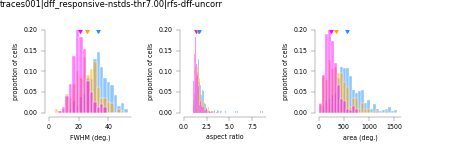

No handles with labels found to put in legend.


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics hist_per-area_metrics


fwhm_avg                                                        \
               count       mean       std        min        25%        50%   
visual_area                                                                  
Li             373.0  33.239836  7.593435  14.186013  28.325986  33.015422   
Lm             229.0  25.808386  7.976604   4.192896  19.962565  25.441415   
V1             555.0  21.320394  5.373961   7.753588  17.994567  20.780352   

                                  aspect_ratio            ...            \
                   75%        max        count      mean  ...       75%   
visual_area                                               ...             
Li           38.260519  52.820103        373.0  1.817151  ...  1.993582   
Lm           30.859410  48.955025        229.0  1.635796  ...  1.772155   
V1           24.082068  38.785655        555.0  1.427571  ...  1.527364   

                        area                                                 \
                  max  count        mean         std        min         25%   
visual_area                                                                   
Li           8.675383  373.0  608.859000  280.980505  77.529152  427.681067   
Lm           4.119268  229.0  390.161546  232.460762   9.030843  215.083713   
V1           3.568268  555.0  264.338898  133.618842  33.913805  176.212724   

                                                  
                    50%         75%          max  
visual_area                                       
Li           567.515025  762.035086  1565.608267  
Lm           342.975316  516.874781  1347.108976  
V1           235.956799  321.941449   785.081282  

[3 rows x 24 columns]

In [92]:
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()

plot_params = ['fwhm_avg', 'aspect_ratio', 'area']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'area': 'area (deg.)'}
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))

ylim=0.2
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=finaldf, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25)
sns.despine(offset=4)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
finaldf.groupby(['visual_area'])[plot_params].describe()

In [29]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


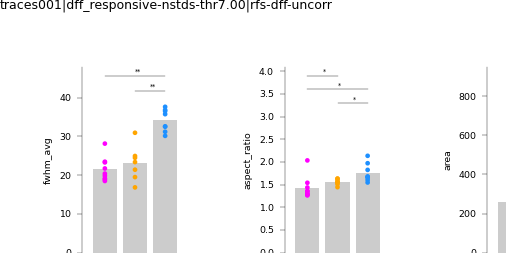

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics per-area_metrics_byFOV


fwhm_avg                                                        \
               count       mean       std        min        25%        50%   
visual_area                                                                  
Li               8.0  34.122643  2.861997  30.119001  32.161614  34.141357   
Lm               7.0  23.050684  4.503134  16.827543  20.436271  23.351542   
V1               9.0  21.472401  3.089696  18.483343  19.140117  20.373303   

                                  aspect_ratio            ...            \
                   75%        max        count      mean  ...       75%   
visual_area                                               ...             
Li           36.563833  37.614335          8.0  1.761300  ...  1.861762   
Lm           24.694009  30.915146          7.0  1.557450  ...  1.606191   
V1           23.269577  28.117552          9.0  1.428356  ...  1.436478   

                       area                                                  \
                  max count        mean         std         min         25%   
visual_area                                                                   
Li           2.135739   8.0  599.852217   92.511659  479.815301  526.186122   
Lm           1.632276   7.0  297.018116  125.064752  153.402093  222.618476   
V1           2.034462   9.0  257.133019   73.104899  186.336941  200.780923   

                                                
                   50%         75%         max  
visual_area                                     
Li           601.70841  657.808496  753.589719  
Lm           283.61265  327.615914  541.643285  
V1           223.07985  306.411695  407.067358  

[3 rows x 24 columns]

In [100]:
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()

plot_params = ['fwhm_avg', 'aspect_ratio', 'area']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'area': 'area (deg^2)'
           }
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,3),dpi=150)
fov_meds = finaldf.groupby(['visual_area', 'datakey']).median().reset_index()

for ax, par in zip(axn.flat, plot_params):
    y_loc=np.ceil(fov_meds[par].max())
    offset = y_loc/10.
    pplot.stripplot_metric_by_area(fov_meds, ax=ax, metric=par,markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc+offset, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
    ax.set_xticklabels('')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, markerscale=0.5)
pplot.adjust_subplots(bottom=0.25)
sns.despine(offset=4, bottom=True)

pplot.label_figure(fig, data_id)
figname = 'per-area_metrics_byFOV'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
fov_meds.groupby(['visual_area'])[plot_params].describe()

<IPython.core.display.Javascript object>


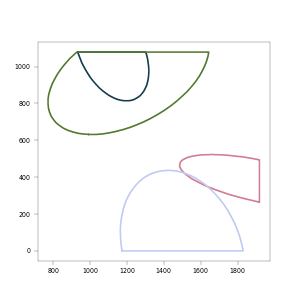

20190430_JC078_fov1
20190522_JC089_fov1
20190622_JC085_fov1
20191017_JC113_fov1


In [28]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(4,4))
col_list = sns.color_palette('cubehelix', n_colors=len(check_rfs))
for col, (dk, check_r) in zip(col_list, check_rfs.items()):
    print(dk)
    for rid, poly1 in check_r:
        ax.plot(*poly1.exterior.xy, color=col)
ax.set_aspect('equal')

In [39]:
aligned_soma.head()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,dist_scatter_ap,inbounds,gradient_R2_ml,gradient_R2_ap,gradient_RMSE_ml,gradient_RMSE_ap,gradient_coefficient_ml,gradient_coefficient_ap,gradient_intercept_ml,gradient_intercept_ap
0,13.970937,-5.799440,20.774773,16.374824,3.430451,-0.008447,0.113912,0.554930,8.840329,6.968010,...,284.600976,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
1,22.098769,-0.247358,39.817408,27.308256,0.420156,-0.001327,0.089209,0.714423,16.943578,11.620534,...,80.923033,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
2,16.905663,-3.145847,30.761553,22.510953,0.578259,0.001873,0.048070,0.634111,13.090023,9.579129,...,118.255902,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
3,15.673189,-1.585387,36.035211,24.158411,0.186008,0.000862,0.145984,0.882504,15.334132,10.280175,...,159.752796,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
4,8.047332,-0.022934,38.349915,24.485321,0.142442,0.000688,0.086568,0.789373,16.319113,10.419285,...,134.461691,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389


In [101]:
projdf = sct.stack_axes(aligned_soma)


In [102]:
projdf.head()

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,gradient_R2,gradient_RMSE,gradient_coefficient,gradient_intercept,axis
0,rfs10,Li,20190527_JC092_fov3,1,0.554930,3.430451,-0.008447,0.113912,-0.050962,1.268702,...,498.266807,17.179469,519.836486,-3.208532,27.425735,0.996587,1.052717,0.11699,-44.321214,az
1,rfs10,Li,20190527_JC092_fov3,2,0.714423,0.420156,-0.001327,0.089209,-0.034325,1.458072,...,567.741491,19.540298,598.021431,2.558471,21.869177,0.996587,1.052717,0.11699,-44.321214,az
2,rfs10,Li,20190527_JC092_fov3,4,0.634111,0.578259,0.001873,0.048070,0.014424,1.366515,...,523.352114,16.997513,548.971182,-0.091849,0.785106,0.996587,1.052717,0.11699,-44.321214,az
3,rfs10,Li,20190527_JC092_fov3,5,0.882504,0.186008,0.000862,0.145984,-0.124330,1.491622,...,512.817232,13.940257,540.463664,1.732932,14.812671,0.996587,1.052717,0.11699,-44.321214,az
4,rfs10,Li,20190527_JC092_fov3,9,0.789373,0.142442,0.000688,0.086568,-0.158003,1.566241,...,447.633299,6.764483,476.545025,1.282848,10.965467,0.996587,1.052717,0.11699,-44.321214,az


In [103]:
projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()
projdf['dist_scatter_abs'] = projdf['dist_scatter'].abs()

In [104]:
az_min, az_max = (-60, 60)
az_step = 2.5
az_bins = np.arange(az_min, az_max+az_step, az_step)

el_min, el_max = (-40, 40)
el_step = 2.5
el_bins = np.arange(az_min, az_max+az_step, az_step)

df = finaldf.copy()
df = cr.cut_bins(df, az_bins, 'x0')
df = cr.cut_bins(df, el_bins, 'y0')

<IPython.core.display.Javascript object>


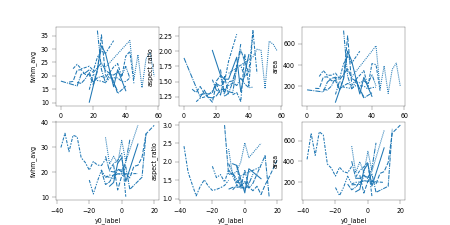

In [105]:
fig, axn = pl.subplots(2,3, figsize=(6,3), sharex=False, sharey=False)

for ai, axcond in enumerate(['x0', 'y0']):
    x_var = '%s_label' % axcond
    fov_means = df.groupby(['visual_area', 'datakey', x_var]).mean().reset_index()
    plotd = fov_means[(fov_means.visual_area=='V1')]
    ax=axn[ai, 0]
    sns.lineplot(x=x_var, y='fwhm_avg', style='datakey', data=plotd, ax=ax,
                lw=1)
    ax.legend_.remove()

    ax=axn[ai, 1]
    sns.lineplot(x=x_var, y='aspect_ratio', style='datakey', data=plotd, ax=ax,
                lw=1)
    ax.legend_.remove()

    ax=axn[ai, 2]
    sns.lineplot(x=x_var, y='area', style='datakey', data=plotd, ax=ax,
                lw=1)
    ax.legend_.remove()
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[0]
# sns.scatterplot(x='x0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)

In [106]:
axis_colors={'az': 'blue', #[0.7]*3,
             'el': 'orange'} #[0.5]*3}

<IPython.core.display.Javascript object>


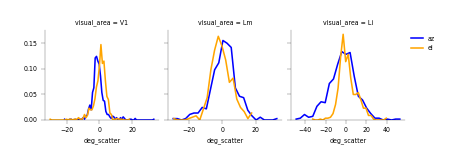

<IPython.core.display.Javascript object>


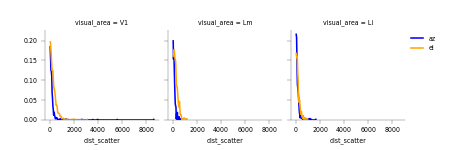

In [107]:
x_var = 'deg_scatter'
%matplotlib notebook
plot_cdf=False
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   #row='experiment', row_order=['rfs', 'rfs10'],
                  data=projdf, hue='axis', palette=axis_colors, height=2,
                  sharex=False)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=projdf, hue='axis', palette=axis_colors, height=2)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

## Greater scatter with eccentricity?

In [108]:
az_min, az_max = (0, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)

df = projdf.copy()
df = cr.cut_bins(df, x_bins, 'eccentricity')
df = cr.cut_bins(df, x_bins, 'eccentricity_ctr')

<IPython.core.display.Javascript object>


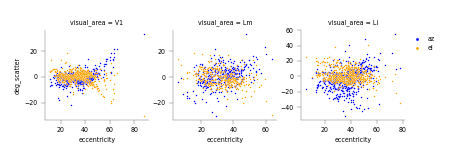

In [109]:

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, 'eccentricity', 'deg_scatter', s=2)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
#sns.scatterplot(x='rf_pos', y='deg_scatter', ax=ax, data=projdf)

<IPython.core.display.Javascript object>


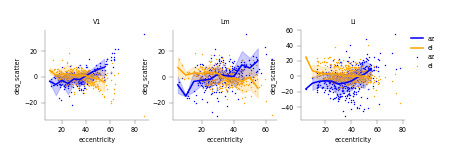

In [112]:
y_var='deg_scatter'
dist_var = 'eccentricity'
scatter_kws = {'size': 2}
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    plotd = binned_df[binned_df.visual_area==ax.title.get_text()].copy()
    sns.lineplot(x=x_var, y=y_var, hue='axis', data=plotd, ax=ax,
                palette=axis_colors, ci='sd')
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()
#     sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
#                  color='k',  ci='sd')

<IPython.core.display.Javascript object>


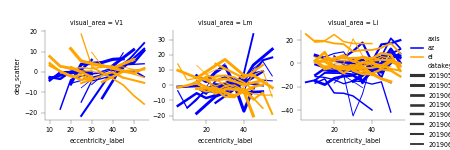

In [113]:
x_var='eccentricity_label'
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var])\
              .mean().reset_index()
plotd = binned_df.copy()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=plotd, height=2,
                  sharex=False, sharey=False)
fg.map(sns.lineplot, x_var, 'deg_scatter', 'axis', 'datakey',
       hue='axis', palette=axis_colors) #, scatter_kws=scatter_kws)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

## RF size ("CMF" for single-cell) vs. eccentricity?

<IPython.core.display.Javascript object>


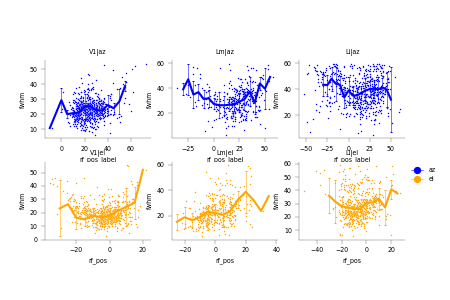

In [114]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
dist_var='rf_pos'
az_min, az_max = (-30, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)
df = projdf.copy()
df = cr.cut_bins(df, x_bins, dist_var)
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                   row='axis',
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}|{row_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    va, cnd = ax.title.get_text().split('|')
    plotd = binned_df[(binned_df.visual_area==va) & (binned_df.axis==cnd)].copy()
    sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
                 hue='axis', palette=axis_colors, 
                 ci='sd', err_style='bars',
                 lw=2, err_kws={'elinewidth':0.5, 'capsize':0.5})
    ax.legend_.remove()
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


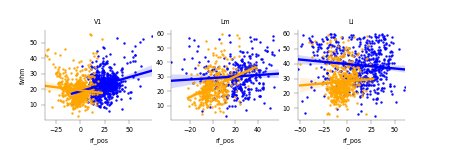

<IPython.core.display.Javascript object>


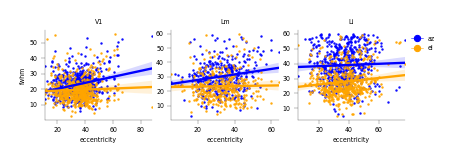

In [115]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
x_var='rf_pos'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='eccentricity'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


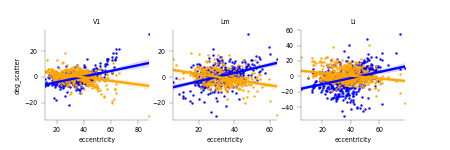

<IPython.core.display.Javascript object>


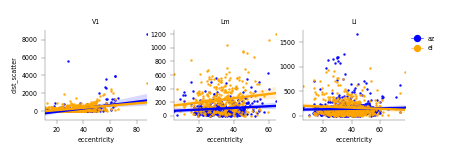

In [116]:
x_var = 'eccentricity'
y_var = 'deg_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var = 'eccentricity'
y_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

#legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

In [117]:
projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()

In [118]:
cnts_fov = pd.concat([pd.DataFrame({'visual_area': va,
               'datakey': dk, 
               'n_cells': len(g['cell'].unique())}, index=[i])\
              for i, ((va, dk), g) in enumerate(df.groupby(['visual_area', 'datakey']))])

for (va, dk), g in df.groupby(['visual_area', 'datakey']):
    df.loc[g.index, 'n_cells'] = len(g['cell'].unique()) #len(df[() & ()]['cell'].unique())
    
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()

<IPython.core.display.Javascript object>


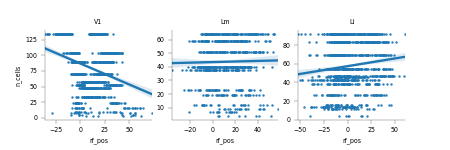

No handles with labels found to put in legend.


In [120]:
y_var = 'n_cells'
x_var =  dist_var # '%s_label' % dist_var
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=binned_df, palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.regplot, dist_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)


# Aggregate RF comparisons

In [127]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [128]:
va='V1'
dk='20190617_JC097_fov1'
df_ = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()


In [148]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [149]:
diffs = cr.get_pw_rf_diffs(df_)
diffs.head()

,neuron_pair,cell_1,cell_2,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,rf_distance,max_ecc,min_ecc,cortical_distance
0,2_4,2,4,-18.054274,18.054274,0.523727,1.443144,0.265733,0.528452,37.971013,37.868868,28.925336
1,2_21,2,21,-40.337231,40.337231,2.071493,2.744454,0.043426,4.645020,37.971013,33.367259,173.407980
2,2_24,2,24,-10.904453,10.904453,5.022730,2.708593,0.139090,3.661556,37.971013,35.267235,255.860257
3,2_25,2,25,-27.924389,27.924389,1.832507,0.890939,0.079702,3.882982,37.971013,34.794594,275.607469
4,2_26,2,26,-30.033266,30.033266,2.181121,2.739271,0.024010,3.073550,37.971013,35.012558,269.231332


In [130]:
rois_ = df_['cell'].unique()
curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
print(dk, curr_polys.shape)
if len(curr_polys)<=1:
    print("NONE, skipping overlaps")  
overlaps_ = rfutils.get_rf_overlaps(curr_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
                                in overlaps_[['cell_1', 'cell_2']].values] 

20190617_JC097_fov1 (77, 3)


In [133]:
from functools import reduce

In [150]:
dfs_to_merge=[diffs, overlaps_]

# combine
pw_df = reduce(lambda  left,right: pd.merge(left,right,\
                                    on=['neuron_pair', 'cell_1', 'cell_2'],
                                    how='outer'), dfs_to_merge)

In [151]:
diffs.columns

Index(['neuron_pair', 'cell_1', 'cell_2', 'rf_angle_diff', 'rf_angle_diff_abs',
       'std_x', 'std_y', 'aspect_ratio', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance'],
      dtype='object')

In [152]:
overlaps_.columns

Index(['cell_1', 'cell_2', 'area_overlap', 'perc_overlap', 'neuron_pair'], dtype='object')

In [156]:
rf_diff_params

['neuron_pair',
 'rf_angle_diff',
 'rf_angle_diff_abs',
 'std_x',
 'std_y',
 'aspect_ratio',
 'rf_distance',
 'max_ecc',
 'min_ecc',
 'cortical_distance',
 'area_overlap',
 'perc_overlap']

<IPython.core.display.Javascript object>


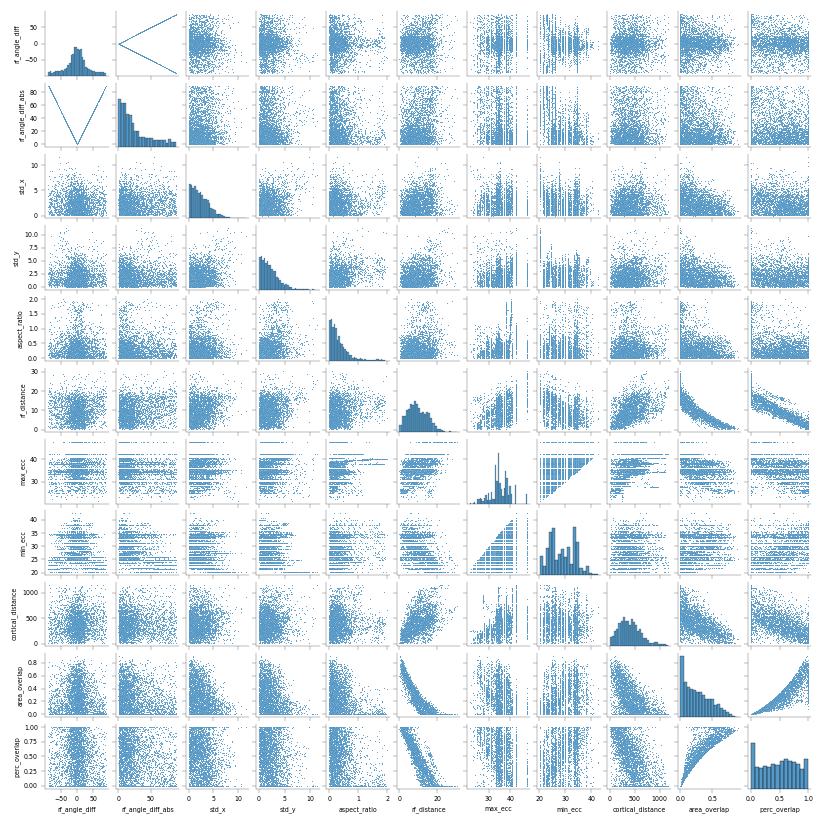

In [159]:
rf_diff_params = [c for c in pw_df.columns \
                  if c not in ['neuron_pair', 'cell_1', 'cell_2']]
sns.pairplot(pw_df, vars=rf_diff_params, height=1, plot_kws={'s':1})
pl.savefig(os.path.join(dst_dir, 'pairplot_rf_metrics.svg'))


In [158]:
DISTS = cr.aggregate_rf_dists(finaldf, rfpolys=rfpolys)

20190527_JC092_fov3 (46, 3)
20190528_JC092_fov1 (11, 3)
20190602_JC091_fov1 (84, 3)
20190612_JC099_fov1 (54, 3)
20190614_JC091_fov1 (92, 3)
20190617_JC099_fov1 (16, 3)
20191017_JC113_fov1 (43, 3)
20191106_JC120_fov1 (26, 3)
20190430_JC078_fov1 (38, 3)
20190504_JC078_fov1 (9, 3)
20190508_JC083_fov1 (64, 3)
20190525_JC084_fov1 (40, 3)
20190603_JC080_fov1 (59, 3)
20190618_JC097_fov1 (12, 3)
20190627_JC091_fov1 (7, 3)
20190501_JC076_fov1 (9, 3)
20190507_JC083_fov1 (58, 3)
20190508_JC083_fov1 (15, 3)
20190522_JC084_fov1 (134, 3)
20190613_JC097_fov1 (70, 3)
20190616_JC097_fov1 (103, 3)
20190617_JC097_fov1 (89, 3)
20190622_JC085_fov1 (24, 3)
20191006_JC110_fov1 (53, 3)


In [160]:
DISTS['area_overlap'] = DISTS['area_overlap'].astype(float)
DISTS['perc_overlap'] = DISTS['perc_overlap'].astype(float)
DISTS.groupby('visual_area').count()

,neuron_pair,cell_1,cell_2,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,rf_distance,max_ecc,min_ecc,cortical_distance,area_overlap,perc_overlap,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,
Li,11567,11567,11567,11567,11567,11567,11567,11567,11567,11567,11567,11567,11541,11541,11567,11567
Lm,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333
V1,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943


In [255]:
ctx_maxdist=1200
equal_bins=False
n_bins=10

df = DISTS.copy()
# Split distances into X um bins
ctx_step=10
if equal_bins:
    ctx_bins = np.linspace(0, ctx_maxdist, n_bins)
else:
    ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2
curr_maxdist = DISTS[(DISTS.visual_area==va) 
                    & (DISTS.datakey==dk)]['rf_distance'].max()
if equal_bins:
    rf_bins = np.linspace(0, curr_maxdist, n_bins)
else:
    rf_bins = np.arange(0, 40+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.02
if equal_bins:
    perc_bins = np.linspace(0, 1, n_bins)
else:
    perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')
# Split
dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step}           }

<IPython.core.display.Javascript object>


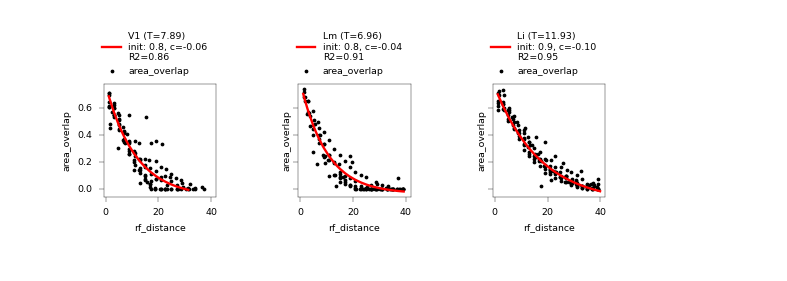

In [256]:
%matplotlib notebook
metric='area_overlap'
to_quartile = 'rf_distance'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)

xlabel='cortical dist (um)' if to_quartile=='cortical_distance' \
    else to_quartile
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), dpi=150, sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index() #.dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

# Bootstrap decay fit

In [257]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [293]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='area_overlap'
to_quartile='cortical_distance'
# --------------------------------------------------
ymax = 1 if metric=='area_overlap' else None

cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=100
# Fit function
resdf = cr.bootstrap_fitdecay(df.dropna(), use_binned=use_binned, 
                         fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         bin_column='bin_value', normalize_x=True, ymax=ymax,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
(240, 6)


In [294]:
print("init: %i/%i iters too big" % (resdf[resdf.init>1].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<=-1].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>1200].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.init<=0].shape[0], n_iterations))


init: 100/100 iters too big
init: 0/100 iters too small
tau: 0/100 iters too big
tau: 0/100 iters too small


In [295]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=1.2) & (resdf['init']>=-1.2) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=1200) & (resdf['tau']>=0)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(300, 6) (200, 6)


In [296]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

cortical distance (um)
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics cortical_distance_v_area_overlap_curves_cut-fitraw-avgfov


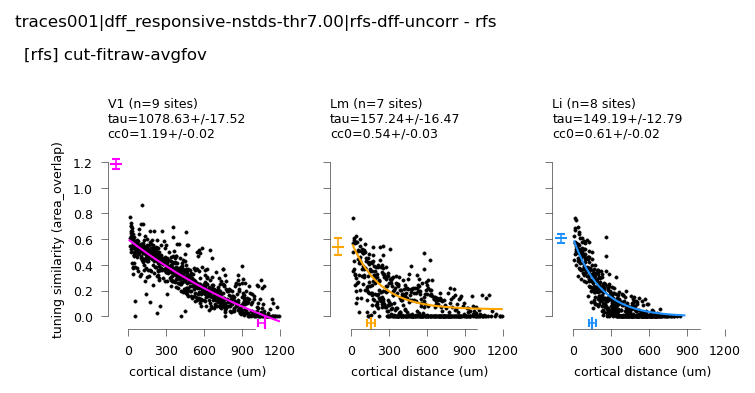

In [303]:
ylim=(-0.1,1.3)
%matplotlib inline
if to_quartile=='area_overlap':
    x_pos = -0.1
    xlabel='RF overlap (%)'
    max_dist = 1
else:
    x_pos = -100 if to_quartile=='cortical_distance' else -5
    y_pos = -0.05 if metric=='area_overlap' else -0.75
    xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
    max_dist = 1200 if to_quartile=='cortical_distance' else 40
    
ylabel='tuning similarity (%s)' % metric
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=y_pos, elinewidth=0.75,
                            ylim=ylim, xlabel=xlabel, ylabel=ylabel)
fig.patch.set_alpha(1)
for ax in fig.axes:
    yticks=np.linspace(0, 1.2, 7)
    ax.set_yticks(yticks)
    ax.set_yticklabels([round(i, 2) for i in yticks])
    xticks = np.linspace(0, max_dist, 5)
    ax.set_xticks(xticks)
pl.subplots_adjust(bottom=0.3, right=0.8)
fig.text(0.01, 0.9, '[%s] %s' \
             % (experiment, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_v_%s_curves_%s' % (to_quartile,metric, bin_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [304]:
for va, vg in resdf.groupby('visual_area'):
    print('%s --------------------' % va)
    print(vg.describe())
    

Li --------------------
             init         tau    constant          R2
count  100.000000  100.000000  100.000000  100.000000
mean     0.609903  149.555558   -0.003293    0.765734
std      0.016184   12.793899    0.019460    0.022769
min      0.559644  118.713908   -0.054931    0.695291
25%      0.601775  141.425252   -0.014735    0.753848
50%      0.610185  149.191628   -0.003687    0.767740
75%      0.620353  156.371694    0.006479    0.783444
max      0.643511  192.474925    0.050619    0.807639
Lm --------------------
             init         tau    constant          R2
count  100.000000  100.000000  100.000000  100.000000
mean     0.533522  157.591674    0.052997    0.496173
std      0.034847   16.472795    0.009767    0.037019
min      0.456740  124.497294    0.027758    0.420054
25%      0.508467  146.399213    0.045969    0.470125
50%      0.535223  157.244776    0.052581    0.492559
75%      0.552038  166.443400    0.059654    0.516387
max      0.634141  203.801317    0

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics param_distns_cortical_distance_v_area_overlap_cut-fitraw-avgfov


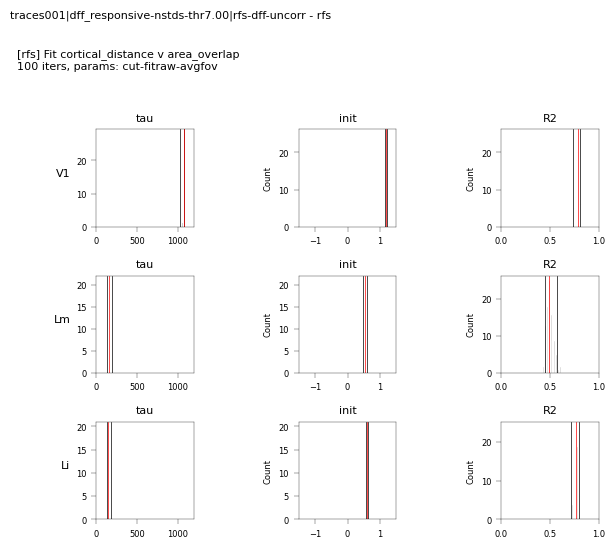

In [305]:
if to_quartile=='area_overlap':
    tau_lim = 1.5
else:
    tau_lim=1200 if to_quartile=='cortical_distance' else 80
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
fig.patch.set_alpha(1)

for va, rd_ in resdf.dropna().groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
        ax.set_box_aspect(1)
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.5, top=0.8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.9, "[%s] Fit %s v %s\n%i iters, params: %s" 
    % (experiment, to_quartile, metric, n_iterations, bin_type), 
         fontsize=8)

figname = 'param_distns_%s_v_%s_%s' % (to_quartile, metric, bin_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [192]:
# dist_var='cortical_distance'
# ctx_maxdist=1200
# ctx_step=25
# ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

# rf_maxdist=60
# rf_step=5
# rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)

# dist_bins = copy.copy(ctx_bins) if dist_var=='cortical_distance' \
#                 else copy.copy(rf_bins)

# diffs = cr.cut_bins(diffs, dist_bins, dist_var)

# grp_step=100 if dist_var=='cortical_distance' else 15
# grp_max = 1000 if dist_var=='cortical_distance' else 60
# grp_bins = np.arange(0, grp_max+grp_step, grp_step)
# diffs['group_value'] = pd.cut(diffs[dist_var], grp_bins, 
#                             include_lowest=True, labels=grp_bins[0:-1])
# diffs['group_label'] = [int(d) if not np.isnan(d) else d \
#                              for d in diffs['group_value'].values]

In [242]:
import pingouin as pg

In [243]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics'

In [244]:
# experiment = 'rfs'
# responsive_test='nstds'
# trial_epoch='stimulus'
# # ----------------------------------------------------------------
# response_type='dff'
# responsive_thr=7.0 if experiment=='rfs' else 10.
# n_stds=2.5
# n_bootstrap_iters=500
# print(responsive_test, responsive_thr)
# # Responsive params
# resp_desc = '%s_responsive-%s-thr%.2f' \
#                 % (response_type, responsive_test, responsive_thr)
# data_id = '|'.join([traceid, resp_desc])
# print(data_id)
# #### Load all metdata and assigned cells
# sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
# meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# #### Output dir
# cc_dir = os.path.join(aggregate_dir, 'correlations', 
#                        '%s_%s_%s' % (experiment, response_type, responsive_test))
# if not os.path.exists(cc_dir):
#     os.makedirs(cc_dir)
# print(cc_dir)

In [245]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in rf_ukeys], ignore_index=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl


In [246]:
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=rfdf,
                        SDF=None, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Dist: rf_distance
0 datasets w wrong configs:
0 datasets w/out RF fits:


In [247]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,rf_distance,max_ecc,min_ecc,cortical_distance,visual_area,datakey,experiment,n_cells
0,1,2,0.722867,1_2,0.194088,9.843133,29.971839,29.339362,31.138301,Li,20190527_JC092_fov3,rfs,65
1,1,4,0.612922,1_4,0.012481,3.956535,29.339362,28.662374,69.239792,Li,20190527_JC092_fov3,rfs,65
2,1,5,0.603857,1_5,0.168463,4.544876,29.339362,26.675416,41.847749,Li,20190527_JC092_fov3,rfs,65
3,1,9,0.370799,1_9,0.083089,8.273882,29.339362,21.579561,98.959469,Li,20190527_JC092_fov3,rfs,65
4,1,14,0.498955,1_14,0.059313,3.166283,29.339362,26.519261,70.586142,Li,20190527_JC092_fov3,rfs,65


In [248]:
CORRS.shape, CORRS.dropna().shape

((202626, 13), (29068, 13))

In [249]:
DISTS.columns

Index(['neuron_pair', 'cell_1', 'cell_2', 'rf_angle_diff', 'rf_angle_diff_abs',
       'std_x', 'std_y', 'aspect_ratio', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance', 'area_overlap', 'perc_overlap', 'visual_area',
       'datakey', 'n_cells'],
      dtype='object')

In [250]:
CORRS.columns

Index(['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
       'rf_distance', 'max_ecc', 'min_ecc', 'cortical_distance', 'visual_area',
       'datakey', 'experiment', 'n_cells'],
      dtype='object')

In [287]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
DF = pd.merge(DISTS, CORRS, on=cc_cols, how='inner')

<IPython.core.display.Javascript object>


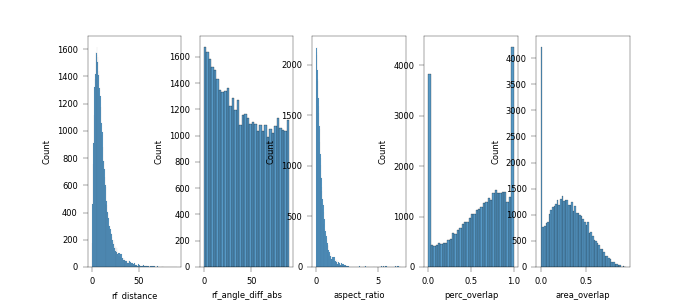

In [296]:
plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(1, len(plot_params), figsize=(7,3))
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=DF, ax=ax)

In [317]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [318]:
ctx_step=20
max_dist=1200
df = DF[DF.cortical_distance<=max_dist].copy()

ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

metric = 'rf_angle_diff_abs'
m_bins = np.linspace(0, 90, 13)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'aspect_ratio'
step = 0.5
m_bins = np.linspace(0, 3, 30)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'perc_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'area_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)


In [319]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

<IPython.core.display.Javascript object>


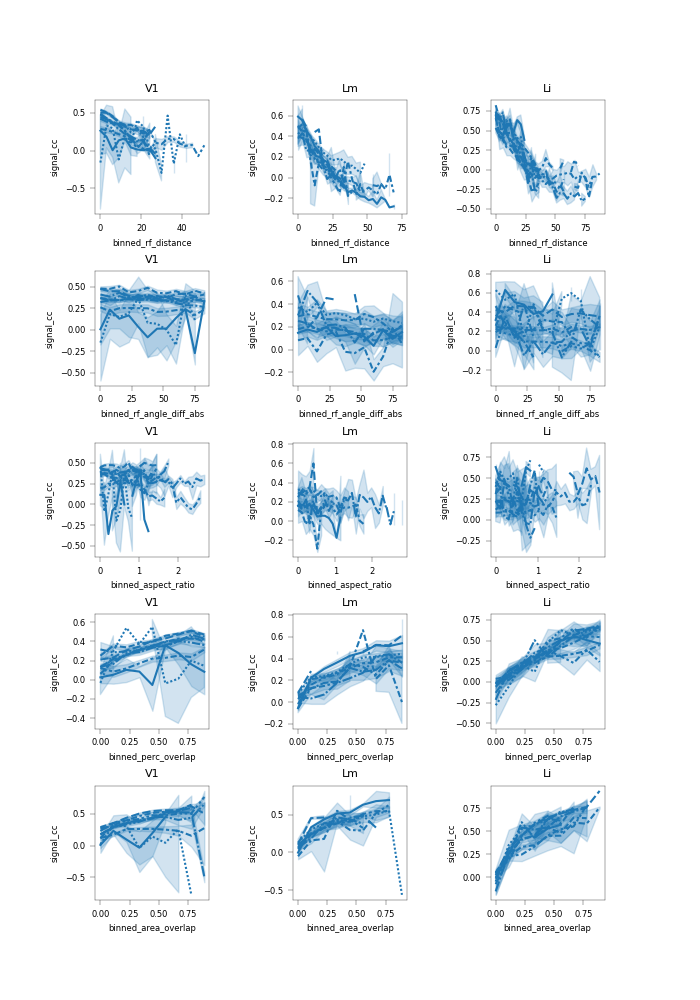

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [320]:
y_var = 'signal_cc'
y_var = 'signal_cc'

plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(len(plot_params),3, figsize=(7,10))
for ri, par in enumerate(plot_params):
    for va, vg in df.groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[ri, vi]
        ax.set_title(va)
        sns.lineplot(x='binned_%s' % par, y=y_var, ax=ax, data=vg,
                    style='datakey')
        ax.legend_.remove()
        ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, hspace=0.5, top=0.9)

In [ ]:
rf_angle_diff_abs

## Overlap v. distance

In [ ]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 6

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    finaldf['binned_dist'], bin_edges = pd.qcut(finaldf['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    finaldf['binned_dist'], bin_edges = pd.cut(finaldf['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

In [235]:
meanf = finaldf.groupby(['visual_area', 'datakey', 'experiment', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


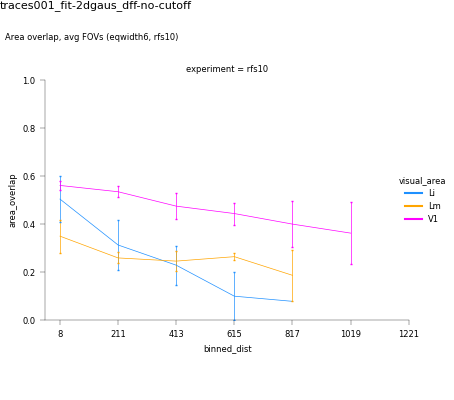

In [236]:
lw=0.5
metric='area_overlap'
fg = sns.relplot(x='binned_dist', y='area_overlap', hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                 err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Area overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


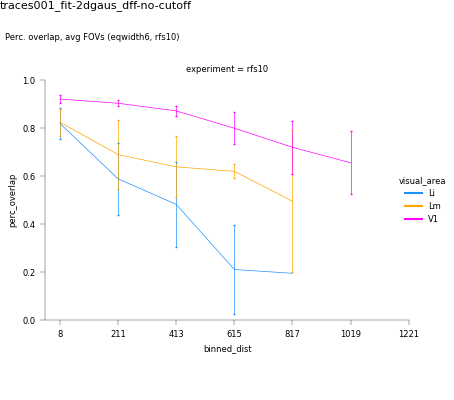

In [237]:
metric='perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Perc. overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


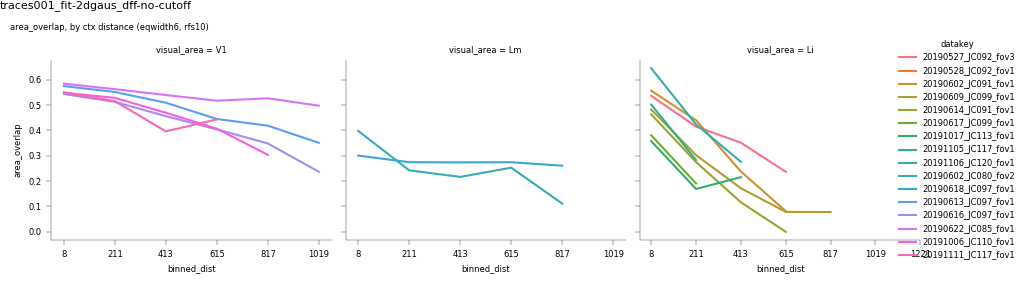

In [240]:
# fig, ax = pl.sublots()
metric = 'area_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


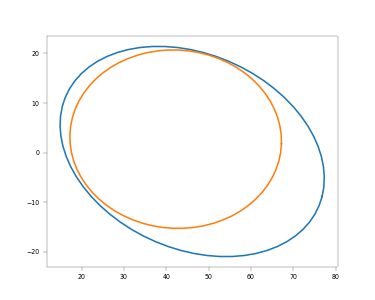

In [256]:
# fig, ax = pl.subplots()
# ax.plot(*rf_polys[4].exterior.xy)
# ax.plot(*rf_polys[11].exterior.xy)


In [ ]:
# # Convert stimuli to polyon bounding boxes
# stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
#               for blob_sz in stim_sizes[experiment]]